<center style="font-size:25px;padding-bottom:10px;">Final - Procesos Estocásticos</center>
<center style="font-size:20px;padding-bottom:10px;">Máster en Ciencia de Datos -  Universidad Autónoma de Madrid</center>
<center style="font-size:20px;padding-bottom:10px;">José Antonio Álvarez Ocete</center>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from collections import defaultdict
from sklearn.linear_model import LinearRegression 

## Ejercicio I

En los apuntes hay el ejemplo del *gambler's ruin* como cadena de Markov. 

**a)** Hacer un gráfico del número medio de jugadas que el jugador puede hacer antes de arruinarse en función del dinero inicial. En cada jugada se juega 1 Euro, y el juego es ecuo (el jugador tiene una probabilidad 1/2 de ganar).

In [4]:
def simulate_gambler_step(p=1/2):
    """ 
        Simulates a single step of the gambler's ruin
        - p: the probability of winning
        - returns: 1 if won, -1 if lost
    """
    r = random.uniform(0, 1)
    return 1 if r <= p else -1

def simulate_gamblers_ruin(initial_money, p=1/2, max_steps=10**6):
    """
        Simulates a gambler's ruin markov chain.
        - initial_money: the starting node
        - p: the probability of winning at each step
        - max_steps: the max number of steps to be comptued
        - returns: time taken to ruin the gambler. If max_steps is reached
            without ruining the gambler, return max_steps instead.
    """
    money = initial_money
    steps = 0
    while money > 0 and steps <= max_steps:
        steps += 1
        money += simulate_gambler_step(p)
    return steps

def plot_mean_ruin_time(max_initial_money=50, n=20, max_steps=10**5, p=1/2):
    """
        Plots the mean time for a gambler's to ruin themself, against the initial money.
        - max_initial_money: max initial money to be plotted
        - n: the number of executions per initial money value
        - max_steps: the max number of steps to be comptued
        - p: the probability of winning at each step
    """
    # Compute times
    initial_money_range = np.arange(1, max_initial_money)
    mean_times = [
        np.mean( [simulate_gamblers_ruin(initial_money, p=p, max_steps=max_steps)
                  for _ in range(n)] )
        for initial_money in initial_money_range
    ]
    
    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(initial_money_range, mean_times, '-o')
    plt.legend(['Mean time to ruin', 'Max iterations'])
    plt.xlabel('Initial money')
    plt.ylabel('Mean time to ruin in {} iterations'.format(n))
    plt.title('Gambler\'s ruin simulation')
    plt.show()

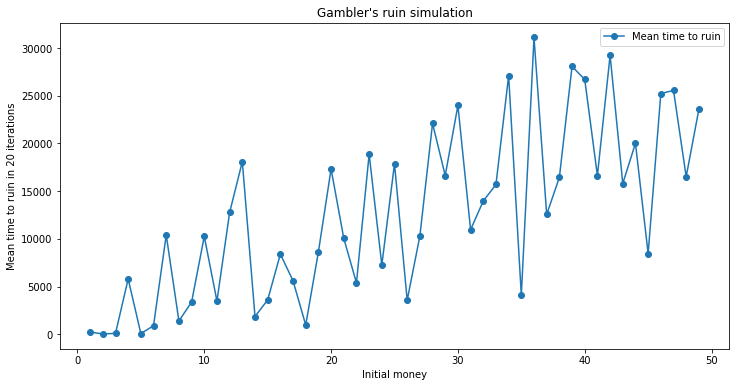

In [5]:
random.seed(123)
plot_mean_ruin_time(max_steps=10**5)

**b)** Estimar media y varianza (usar unas 20 ejecuciones, deberían ser más que suficientes) considerando un dinero inicial de $\{1, \ldots, 50\}$ euros. Indicar media y varianza. ¿Cómo varían la media y la varianza cuando aumenta el dinero inicial?

In [6]:
def mean_and_std_of_ruin_time(initial_money, n=20, max_steps=10**5, p=1/2):
    times = [simulate_gamblers_ruin(initial_money, p=p, max_steps=max_steps)
             for _ in range(n) ]
    return np.mean(times), np.std(times)

def compute_clipped_CI(mean, std, n, alpha=0.05):
    z = stats.norm.ppf(1 - alpha/2)
    std_error = abs(std * z / np.sqrt(n))
    return max(mean - std_error, 0), mean + std_error
    
def plot_ruin_time_estimation(max_initial_money=50, n=20, max_steps=10**5, p=1/2):
    """
        Plots the mean time for a gambler's to ruin themself, against the initial money.
        - max_initial_money: max initial money to be plotted
        - n: the number of 
        - p: the probability of winning at each step
    """
    # Compute times
    initial_money_range = np.arange(1, max_initial_money)
    mean_and_stds = np.array([mean_and_std_of_ruin_time(initial_money, n=n, max_steps=max_steps, p=p)
                     for initial_money in initial_money_range])
    intervals = np.array([ compute_clipped_CI(mean, std, n) for mean, std in mean_and_stds])
    CI_std_min, CI_std_max = np.max(mean_and_stds[:,0] - mean_and_stds[:,1], 0), mean_and_stds[:,0] + mean_and_stds[:,1]
    
    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(initial_money_range, mean_and_stds[:,0], '-o')
    plt.fill_between(initial_money_range, CI_std_min, CI_std_max, color='green', alpha=.3)
    plt.fill_between(initial_money_range, intervals[:,0], intervals[:,1], color='b', alpha=.3)
    plt.legend(['Mean time to ruin', '+- Std', 'Confidence interval'])
    plt.xlabel('Initial money')
    plt.ylabel('Mean time to ruin in {} iterations'.format(n))
    plt.title('Gambler\'s ruin simulation')
    plt.show()

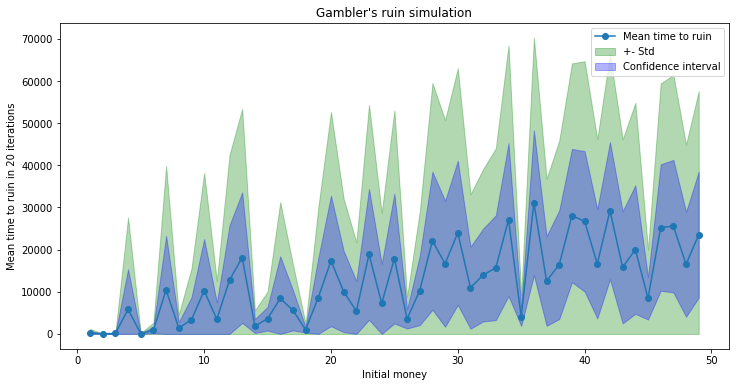

In [10]:
random.seed(123)
plot_ruin_time_estimation()

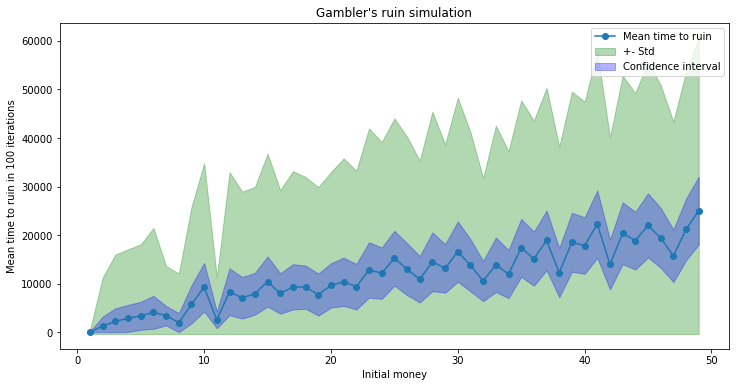

In [11]:
random.seed(123)
plot_ruin_time_estimation(n=100)

**c)** Dar una estimación de la función $T(e)$ que da el tiempo medio necesario para arruinarse en función de la cantidad inicial de dinero, e. Según esta función, ¿cuánto tarda el jugador en arruinarse si empieza a jugar con 200 Euros?

In [13]:
def plot_ruin_time_regression(max_initial_money=50, n=20, max_steps=10**5, p=1/2, display_prediction=True):
    """
        Plots the mean time for a gambler's to ruin themself, against the initial money.
        - max_initial_money: max initial money to be plotted
        - n: the number of 
        - p: the probability of winning at each step
    """
    # Compute times
    initial_money_range = np.arange(1, max_initial_money)
    mean_and_stds = np.array([mean_and_std_of_ruin_time(initial_money, n=n, max_steps=max_steps, p=p)
                     for initial_money in initial_money_range])
    intervals = np.array([ compute_clipped_CI(mean, std, n) for mean, std in mean_and_stds])
    CI_std_min, CI_std_max = np.max(mean_and_stds[:,0] - mean_and_stds[:,1], 0), mean_and_stds[:,0] + mean_and_stds[:,1]
    
    # Compute regression
    X = initial_money_range.reshape(-1, 1)
    y = mean_and_stds[:,0].reshape(-1, 1)
    reg_model = LinearRegression().fit(X, y)
    predictions = reg_model.predict(X)
    
    # Display the prediction for 200 initial money
    if display_prediction:
        result = reg_model.predict(np.array([[200]]))
        print('Prediction for 200 initial money (n={}): {}'.format(n, result[0,0]))
    
    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(initial_money_range, mean_and_stds[:,0], '-o')
    plt.plot(initial_money_range, predictions, color='r')
    plt.fill_between(initial_money_range, CI_std_min, CI_std_max, color='green', alpha=.3)
    plt.fill_between(initial_money_range, intervals[:,0], intervals[:,1], color='b', alpha=.3)
    plt.legend(['Mean time to ruin', 'linear regression', '+- Std', 'Confidence interval'])
    plt.xlabel('Initial money')
    plt.ylabel('Mean time to ruin in {} iterations'.format(n))
    plt.title('Gambler\'s ruin simulation')
    plt.show()

Prediction for 200 initial money (n=94067.22283163268): 20


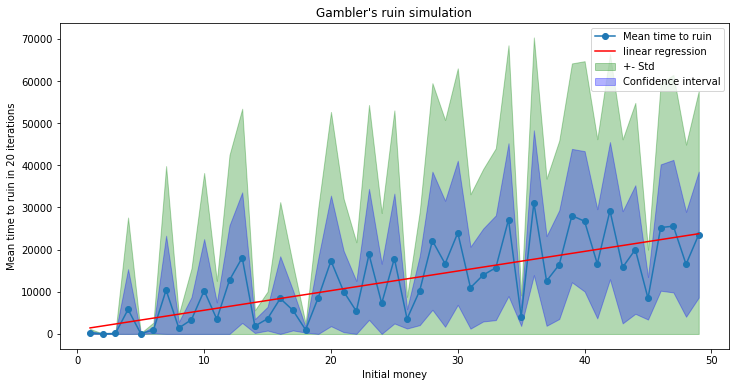

In [14]:
random.seed(123)
plot_ruin_time_regression()

In [15]:
random.seed(123)
plot_ruin_time_regression(n=100)